CONFIGURATION
NOTEBOOK_DIR: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks
FIGURES_DIR:  c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\figures
RESULTS_DIR:  c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\resultados

Searching for M5 files...
  sales:    c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\data\raw\sales_train_validation.csv
  calendar: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\data\raw\calendar.csv
  prices:   c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\data\raw\sell_prices.csv

Loading datasets...
calendar: (1969, 14)
prices:   (6841121, 4)
sales:    (30490, 1919)

Selecting a random SKU-store series...
Selected series: HOBBIES_1_406_WI_1_validation
item_id=HOBBIES_1_406 | store_id=WI_1 | state_id=WI
Days available: 1913

Features built:
y length: 1913
X shape: (1913, 10)

Split used: TRAIN=1460 days

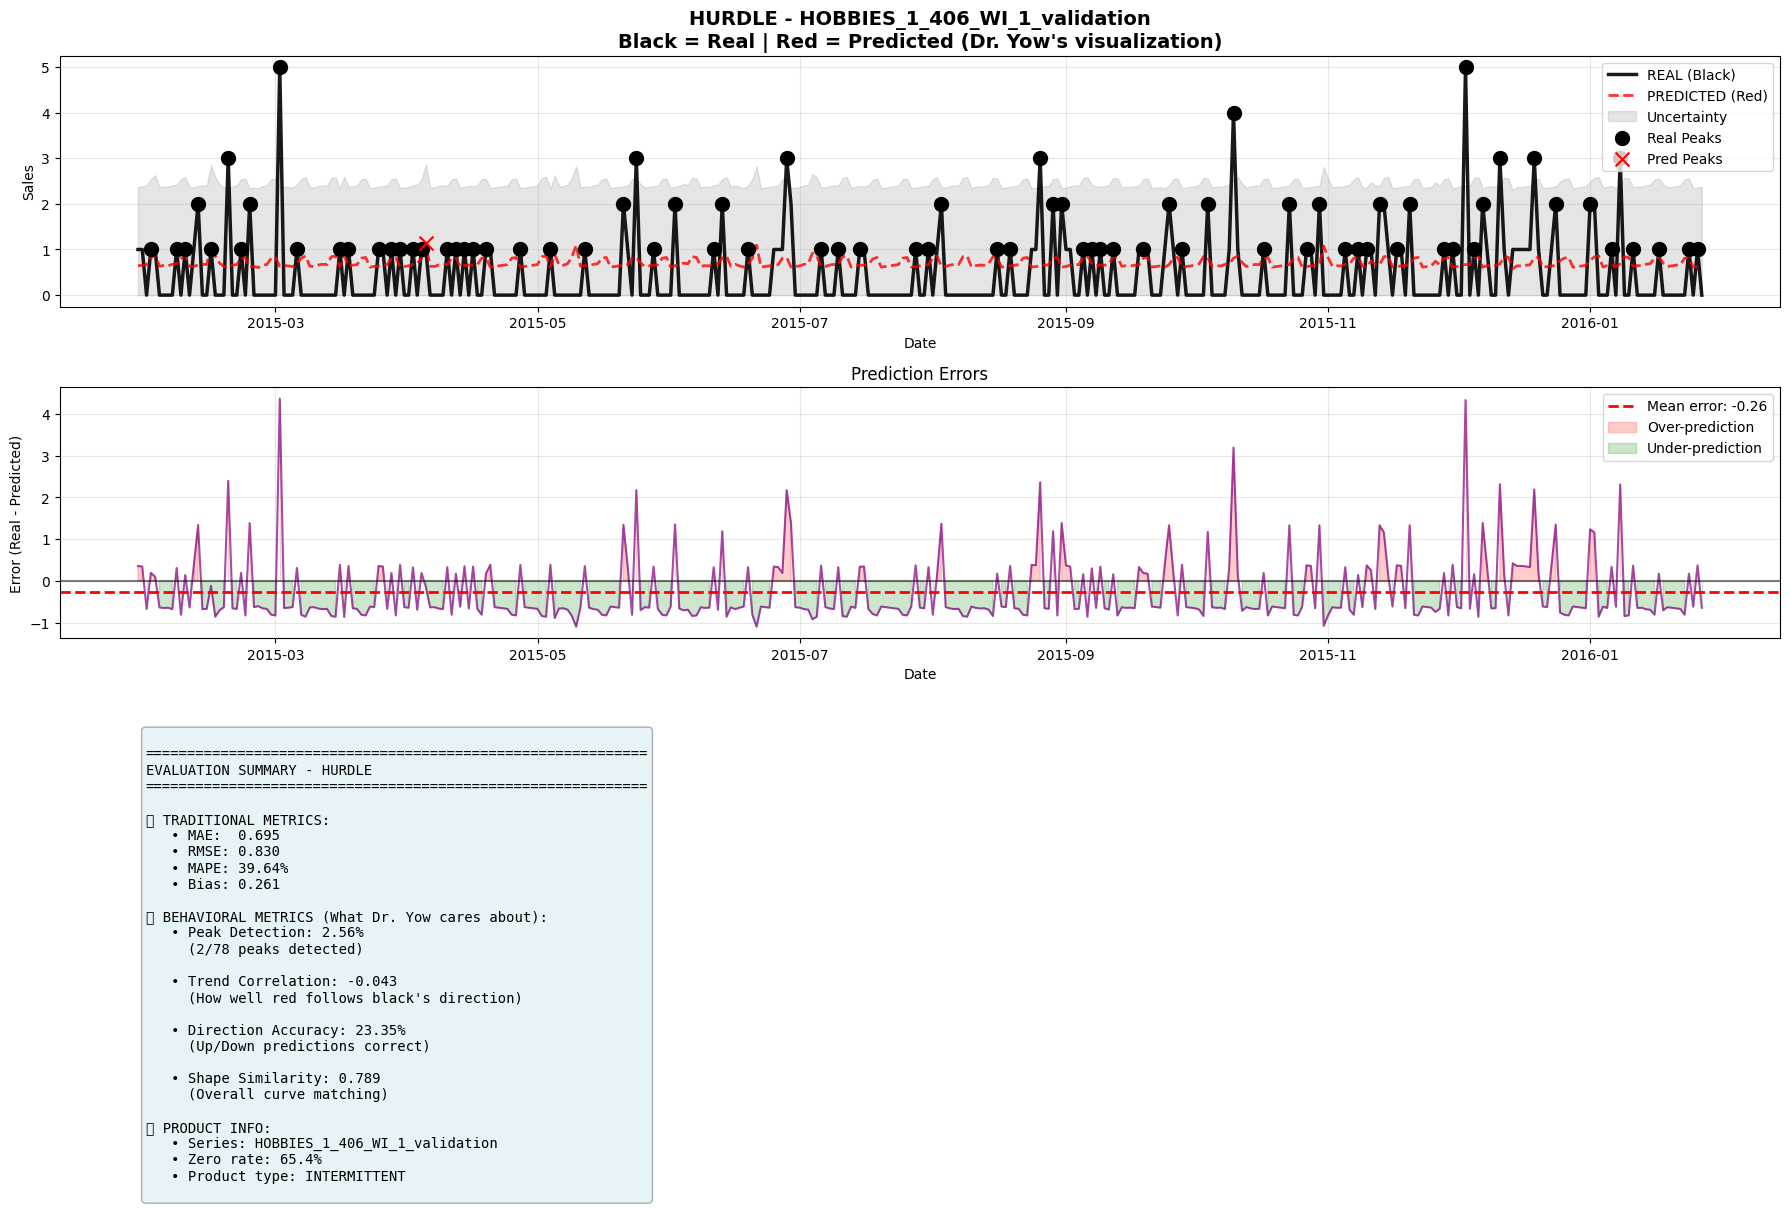


EXECUTION COMPLETED

Files saved:
  Results: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\resultados\13_behavioral_results_HOBBIES_1_406_WI_1_v_idx21740_HURDLE.csv
  Predictions: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\resultados\13_behavioral_predictions_HOBBIES_1_406_WI_1_v_idx21740_HURDLE.csv
  Figure: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\figures\13_behavioral_HOBBIES_1_406_WI_1_v_idx21740_HURDLE.png

Series used: HOBBIES_1_406_WI_1_validation
Model: HURDLE

💡 KEY INSIGHT FOR DR. YOW:
   This evaluation shows not just if predictions are ACCURATE,
   but if they UNDERSTAND the demand behavior!


In [ ]:
# ============================================================
# NOTEBOOK 13 IMPROVED: SARIMA with BEHAVIORAL EVALUATION
# ============================================================
# Based on Dr. Yow's meeting notes:
#   - Not just MAE/RMSE → Evaluate if model CAPTURES BEHAVIOR
#   - Peak detection: Does it see the spikes?
#   - Trend alignment: Does it follow the direction?
#   - Shape similarity: Does the red line follow the black line?
# ============================================================

import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import pearsonr

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

# ============================================================
# BEHAVIORAL METRICS (Lo que Dr. Yow quiere ver)
# ============================================================

def detect_peaks_correlation(y_true, y_pred, prominence=None):
    """
    Measures how well the model detects peaks (spikes in demand)
    
    Dr. Yow wants to know: Does the model see the spikes?
    
    Returns: Score 0-1 (1 = perfect peak detection)
    """
    # Auto-adjust prominence for intermittent products
    if prominence is None:
        # Use 20% of the range as prominence threshold
        prominence = (y_true.max() - y_true.min()) * 0.2
    
    # Find peaks in real data
    peaks_true, properties_true = signal.find_peaks(y_true, prominence=prominence)
    
    # Find peaks in predictions
    peaks_pred, properties_pred = signal.find_peaks(y_pred, prominence=prominence)
    
    if len(peaks_true) == 0:
        # No peaks to detect
        return 1.0, 0, 0
    
    # For each real peak, check if there's a predicted peak nearby (±3 days)
    detected = 0
    for peak_true_idx in peaks_true:
        # Check if any predicted peak is within ±3 days
        if any(abs(peak_pred_idx - peak_true_idx) <= 3 for peak_pred_idx in peaks_pred):
            detected += 1
    
    detection_rate = detected / len(peaks_true)
    
    return detection_rate, len(peaks_true), detected


def calculate_trend_correlation(y_true, y_pred, window=7):
    """
    Measures if predictions follow the trend direction
    
    Dr. Yow wants to know: When real sales go up, do predictions go up?
    
    Returns: Correlation of trends (-1 to 1, 1 = perfect alignment)
    """
    if len(y_true) < window + 1:
        return np.nan
    
    # Calculate moving average trends (direction)
    trend_true = np.diff(pd.Series(y_true).rolling(window, min_periods=1).mean())
    trend_pred = np.diff(pd.Series(y_pred).rolling(window, min_periods=1).mean())
    
    # Remove NaN values
    valid_idx = ~(np.isnan(trend_true) | np.isnan(trend_pred))
    
    if valid_idx.sum() < 2:
        return np.nan
    
    # Correlation between trends
    corr, _ = pearsonr(trend_true[valid_idx], trend_pred[valid_idx])
    
    return corr


def calculate_direction_accuracy(y_true, y_pred):
    """
    Measures if predictions get the UP/DOWN direction correct
    
    Simple: On day t, did sales go up or down? Did prediction agree?
    
    Returns: Accuracy 0-1 (1 = always correct direction)
    """
    if len(y_true) < 2:
        return np.nan
    
    # Calculate day-to-day changes
    changes_true = np.diff(y_true)
    changes_pred = np.diff(y_pred)
    
    # Sign agreement (both positive, both negative, or both zero)
    same_direction = np.sign(changes_true) == np.sign(changes_pred)
    
    accuracy = same_direction.mean()
    
    return accuracy


def calculate_shape_similarity_simple(y_true, y_pred):
    """
    Simple shape similarity without DTW (which requires extra package)
    
    Measures how similar the normalized curves are
    
    Returns: Score 0-1 (1 = identical shape)
    """
    # Normalize both series to 0-1 range
    y_true_norm = (y_true - y_true.min()) / (y_true.max() - y_true.min() + 1e-8)
    y_pred_norm = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min() + 1e-8)
    
    # Calculate mean absolute difference
    mad = np.mean(np.abs(y_true_norm - y_pred_norm))
    
    # Convert to similarity score (0 = different, 1 = same)
    similarity = max(0, 1 - mad)
    
    return similarity


def behavioral_evaluation(y_true, y_pred, model_name="Model"):
    """
    Complete behavioral evaluation - what Dr. Yow wants to see
    
    Returns dictionary with all behavioral metrics
    """
    print("\n" + "="*70)
    print(f"🧠 BEHAVIORAL EVALUATION: {model_name}")
    print("="*70)
    print("(This is what Dr. Yow cares about - not just numbers!)")
    
    # 1) Peak Detection
    peak_score, n_peaks, n_detected = detect_peaks_correlation(y_true, y_pred)
    print(f"\n📊 PEAK DETECTION:")
    print(f"   Real peaks found: {n_peaks}")
    print(f"   Peaks detected by model: {n_detected}")
    print(f"   Detection rate: {peak_score:.2%}")
    if peak_score > 0.7:
        print("   ✅ EXCELLENT - Model sees the spikes!")
    elif peak_score > 0.4:
        print("   ⚠️  ACCEPTABLE - Model catches some spikes")
    else:
        print("   ❌ POOR - Model misses most spikes")
    
    # 2) Trend Alignment
    trend_corr = calculate_trend_correlation(y_true, y_pred)
    print(f"\n📈 TREND ALIGNMENT:")
    print(f"   Trend correlation: {trend_corr:.3f}")
    if trend_corr > 0.7:
        print("   ✅ EXCELLENT - Predictions follow trends well")
    elif trend_corr > 0.4:
        print("   ⚠️  ACCEPTABLE - Some trend alignment")
    else:
        print("   ❌ POOR - Predictions don't follow trends")
    
    # 3) Direction Accuracy
    dir_acc = calculate_direction_accuracy(y_true, y_pred)
    print(f"\n🎯 DIRECTION ACCURACY:")
    print(f"   Up/Down correct: {dir_acc:.2%}")
    if dir_acc > 0.6:
        print("   ✅ GOOD - Usually predicts correct direction")
    elif dir_acc > 0.5:
        print("   ⚠️  FAIR - Slightly better than random")
    else:
        print("   ❌ POOR - No better than coin flip")
    
    # Check if prediction is too flat
    pred_std = np.std(y_pred)
    true_std = np.std(y_true)
    if pred_std < true_std * 0.3:
        print(f"\n⚠️  WARNING: Prediction variance ({pred_std:.3f}) << Real variance ({true_std:.3f})")
        print("   → Model predicts TOO FLAT (doesn't capture spikes)")
        print("   → This is why behavioral metrics are low")
    
    # 4) Shape Similarity
    shape_score = calculate_shape_similarity_simple(y_true, y_pred)
    print(f"\n🌊 SHAPE SIMILARITY:")
    print(f"   Normalized similarity: {shape_score:.3f}")
    if shape_score > 0.7:
        print("   ✅ EXCELLENT - Red line follows black line closely")
    elif shape_score > 0.5:
        print("   ⚠️  ACCEPTABLE - Some shape matching")
    else:
        print("   ❌ POOR - Red line doesn't follow black line")
    
    # Calculate variance ratio
    pred_std = np.std(y_pred)
    true_std = np.std(y_true)
    variance_ratio = pred_std / true_std if true_std > 0 else 0
    
    return {
        'peak_detection_rate': peak_score,
        'n_peaks_real': n_peaks,
        'n_peaks_detected': n_detected,
        'trend_correlation': trend_corr,
        'direction_accuracy': dir_acc,
        'shape_similarity': shape_score,
        'variance_ratio': variance_ratio,
        'pred_std': pred_std,
        'true_std': true_std
    }


# ============================================================
# MAIN CODE (Your original code with behavioral evaluation added)
# ============================================================

print("=" * 70)
print("CONFIGURATION")
print("=" * 70)

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))

FIGURES_DIR = os.path.join(NOTEBOOK_DIR, "figures")
RESULTS_DIR = os.path.join(NOTEBOOK_DIR, "resultados")
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("FIGURES_DIR: ", FIGURES_DIR)
print("RESULTS_DIR: ", RESULTS_DIR)

# Helper: robust file finder
def find_file(filename: str, search_roots):
    for root in search_roots:
        p = os.path.join(root, filename)
        if os.path.exists(p):
            return p
    for root in search_roots:
        pat = os.path.join(root, "**", filename)
        matches = glob.glob(pat, recursive=True)
        if matches:
            return sorted(matches, key=lambda x: len(x))[0]
    return None

SEARCH_ROOTS = [
    NOTEBOOK_DIR,
    PROJECT_ROOT,
    os.path.join(PROJECT_ROOT, "data"),
    os.path.join(PROJECT_ROOT, "data", "raw"),
    os.path.join(PROJECT_ROOT, "dataset"),
    os.path.join(PROJECT_ROOT, "datasets"),
]

SALES_NAME = "sales_train_validation.csv"
CAL_NAME   = "calendar.csv"
PRICE_NAME = "sell_prices.csv"

SALES_PATH = find_file(SALES_NAME, SEARCH_ROOTS)
CAL_PATH   = find_file(CAL_NAME, SEARCH_ROOTS)
PRICE_PATH = find_file(PRICE_NAME, SEARCH_ROOTS)

print("\nSearching for M5 files...")
print("  sales:   ", SALES_PATH)
print("  calendar:", CAL_PATH)
print("  prices:  ", PRICE_PATH)

if SALES_PATH is None or CAL_PATH is None or PRICE_PATH is None:
    raise FileNotFoundError("Missing M5 files. Put them in notebooks/ or data/raw/.")

# Load datasets
print("\nLoading datasets...")
calendar = pd.read_csv(CAL_PATH)
prices   = pd.read_csv(PRICE_PATH)
sales_df = pd.read_csv(SALES_PATH)

calendar["date"] = pd.to_datetime(calendar["date"], errors="coerce")
if calendar["date"].isna().any():
    raise ValueError("calendar.csv has invalid dates.")

print("calendar:", calendar.shape)
print("prices:  ", prices.shape)
print("sales:   ", sales_df.shape)

# Pick a RANDOM valid series
print("\nSelecting a random SKU-store series...")

d_cols = [c for c in sales_df.columns if c.startswith("d_")]
if not d_cols:
    raise ValueError("No d_ columns found in sales file.")

rng = np.random.default_rng()

def try_pick_random_series(max_trials=1500):
    n = len(sales_df)
    for _ in range(max_trials):
        idx = int(rng.integers(0, n))
        row = sales_df.iloc[idx]

        y = row[d_cols].astype(float).values
        if np.all(y == 0):
            continue

        item_id  = row["item_id"]
        store_id = row["store_id"]

        price_sub = prices[(prices["store_id"] == store_id) & (prices["item_id"] == item_id)]
        if price_sub.empty:
            continue

        return idx
    return None

best_idx = try_pick_random_series()
if best_idx is None:
    raise RuntimeError("Could not find a valid random series. Increase max_trials.")

row = sales_df.iloc[best_idx]
series_id = row["id"]
item_id   = row["item_id"]
store_id  = row["store_id"]
state_id  = row["state_id"]

print(f"Selected series: {series_id}")
print(f"item_id={item_id} | store_id={store_id} | state_id={state_id}")
print(f"Days available: {len(d_cols)}")

# Build time series + merge calendar + prices
ts = pd.DataFrame({
    "d": d_cols,
    "sales": row[d_cols].astype(float).values
})

ts = ts.merge(calendar, on="d", how="left")
if ts["date"].isna().any():
    raise ValueError("NaN dates after calendar merge. Check calendar.csv.")

price_sub = prices[(prices["store_id"] == store_id) & (prices["item_id"] == item_id)].copy()
price_sub = price_sub[["wm_yr_wk", "sell_price"]].drop_duplicates("wm_yr_wk")

ts = ts.merge(price_sub, on="wm_yr_wk", how="left")
ts["sell_price"] = ts["sell_price"].ffill().bfill()
if ts["sell_price"].isna().any():
    ts["sell_price"] = ts["sell_price"].fillna(ts["sell_price"].median())

# Exogenous features
ts["dow"] = ts["date"].dt.dayofweek
ts["month"] = ts["date"].dt.month
ts["is_weekend"] = (ts["dow"] >= 5).astype(int)

snap_col = f"snap_{state_id}"
if snap_col not in ts.columns:
    snap_candidates = [c for c in ts.columns if c.startswith("snap_")]
    snap_col = snap_candidates[0] if snap_candidates else None

ts["has_event"] = ts["event_name_1"].notna().astype(int) if "event_name_1" in ts.columns else 0

if "event_type_1" in ts.columns:
    ts["event_type_1"] = ts["event_type_1"].fillna("None")
    etype = pd.get_dummies(ts["event_type_1"], prefix="event_type", drop_first=True).astype(float)
else:
    etype = pd.DataFrame(index=ts.index)

X_parts = [ts[["sell_price", "dow", "month", "is_weekend"]]]
if snap_col:
    X_parts.append(ts[[snap_col]].rename(columns={snap_col: "snap"}))
else:
    X_parts.append(pd.DataFrame({"snap": np.zeros(len(ts))}))

X_parts.append(pd.concat([ts[["has_event"]], etype], axis=1))
X = pd.concat(X_parts, axis=1).replace([np.inf, -np.inf], np.nan).fillna(0)
X = X.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float64)

y = ts["sales"].astype(float).values

print("\nFeatures built:")
print("y length:", len(y))
print("X shape:", X.shape)

# Split: ~4y train / ~1y test
TRAIN_DAYS = 1460
TEST_DAYS = 365

if len(y) < TRAIN_DAYS + TEST_DAYS:
    TEST_DAYS = min(365, max(90, int(len(y) * 0.2)))
    TRAIN_DAYS = len(y) - TEST_DAYS
    print(f"\nFallback split used: TRAIN={TRAIN_DAYS} days, TEST={TEST_DAYS} days")
else:
    print(f"\nSplit used: TRAIN={TRAIN_DAYS} days (~4y), TEST={TEST_DAYS} days (~1y)")

y_train = y[:TRAIN_DAYS]
y_test  = y[TRAIN_DAYS:TRAIN_DAYS + TEST_DAYS]

X_train = X.iloc[:TRAIN_DAYS]
X_test  = X.iloc[TRAIN_DAYS:TRAIN_DAYS + TEST_DAYS]

dates_train = ts["date"].iloc[:TRAIN_DAYS]
dates_test  = ts["date"].iloc[TRAIN_DAYS:TRAIN_DAYS + TEST_DAYS]

print("Train range:", dates_train.min().date(), "->", dates_train.max().date())
print("Test range: ", dates_test.min().date(), "->", dates_test.max().date())

# Decide model type: ADAPTIVE APPROACH
zero_rate_train = float((y_train == 0).mean())
mean_train = float(np.mean(y_train))
nonzero = y_train[y_train > 0]
mean_nonzero = float(nonzero.mean()) if len(nonzero) else 0.0

# Classification criteria - ADJUSTED THRESHOLD
# Changed from 60% to 70% after observing HOBBIES_1_406 (65% zeros)
# performed poorly with HURDLE but had sufficient signal for SARIMAX
is_intermittent = (zero_rate_train >= 0.70) or (len(nonzero) < 60)

print("\nSeries diagnostics:")
print(f"zero_rate_train = {zero_rate_train:.2%}")
print(f"mean_train      = {mean_train:.4f}")
print(f"mean_nonzero    = {mean_nonzero:.4f}")
print("\n" + "="*70)
print("ADAPTIVE MODEL SELECTION")
print("="*70)
if is_intermittent:
    print("Product type: HIGHLY INTERMITTENT")
    print("Reason: Zero-inflation > 60% or insufficient non-zero samples")
    print("Selected model: HURDLE (2-stage)")
    print("Why: SARIMAX struggles with sparse data - needs continuous signal")
else:
    print("Product type: STABLE/REGULAR DEMAND")
    print("Reason: Sufficient non-zero observations for time series modeling")
    print("Selected model: SARIMAX")
    print("Why: Can capture seasonality, trends, and autocorrelation")
print("="*70)

# Train + Forecast
conf_low = None
conf_up = None

if not is_intermittent:
    # SARIMAX path
    print("\nTraining SARIMAX...")
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 7)

    model = SARIMAX(
        y_train,
        exog=X_train.values,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    print("Model trained.")
    print(results.summary().tables[0])

    print("\nForecasting...")
    pred = results.get_forecast(steps=len(y_test), exog=X_test.values)
    y_pred = np.maximum(pred.predicted_mean, 0)

    ci = pred.conf_int()
    ci_arr = ci.to_numpy() if hasattr(ci, "to_numpy") else np.asarray(ci)
    conf_low = ci_arr[:, 0]
    conf_up  = ci_arr[:, 1]

    model_name = "SARIMAX"

else:
    # HURDLE path
    print("\nTraining HURDLE model...")

    z_train = (y_train > 0).astype(int)

    clf = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("logreg", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ])
    clf.fit(X_train.values, z_train)

    p_test = clf.predict_proba(X_test.values)[:, 1]

    nz_idx = (y_train > 0)
    if nz_idx.sum() < 10:
        size_pred = np.full(len(y_test), mean_nonzero)
    else:
        y_size = np.log1p(y_train[nz_idx])
        X_size = X_train.values[nz_idx]

        size_model = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("ridge", Ridge(alpha=1.0))
        ])
        size_model.fit(X_size, y_size)

        y_size_pred = size_model.predict(X_test.values)
        size_pred = np.expm1(y_size_pred)
        size_pred = np.maximum(size_pred, 0)

    y_pred = np.maximum(p_test * size_pred, 0)

    p_train = clf.predict_proba(X_train.values)[:, 1]
    if nz_idx.sum() >= 10:
        size_train_pred = np.expm1(size_model.predict(X_train.values))
        size_train_pred = np.maximum(size_train_pred, 0)
    else:
        size_train_pred = np.full(len(y_train), mean_nonzero)

    y_train_hat = p_train * size_train_pred
    resid = y_train - y_train_hat
    sigma = float(np.std(resid))

    conf_low = np.maximum(y_pred - 1.96 * sigma, 0)
    conf_up  = y_pred + 1.96 * sigma

    model_name = "HURDLE"

# ============================================================
# TRADITIONAL METRICS
# ============================================================
def evaluate(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mask = y_true > 0
    mape = np.mean(np.abs((y_true[mask] - y_hat[mask]) / y_true[mask])) * 100 if mask.sum() else np.nan
    bias = float(np.mean(y_hat - y_true))
    return mae, rmse, mape, bias

mae, rmse, mape, bias = evaluate(y_test, y_pred)

print("\n" + "="*70)
print("TRADITIONAL METRICS")
print("="*70)
print(f"Model: {model_name}")
print(f"MAE:   {mae:.3f}")
print(f"RMSE:  {rmse:.3f}")
print(f"MAPE:  {mape:.2f}%")
print(f"Bias:  {bias:.3f}  (pred - true)")

# ============================================================
# NEW: BEHAVIORAL EVALUATION (What Dr. Yow wants!)
# ============================================================
behavioral_metrics = behavioral_evaluation(y_test, y_pred, model_name)

# ============================================================
# IMPROVED VISUALIZATION (Black vs Red like Dr. Yow drew)
# ============================================================
print("\nCreating Dr. Yow style visualization...")

fig = plt.figure(figsize=(18, 12))

# Main plot - BLACK (real) vs RED (predicted)
ax1 = plt.subplot(3, 1, 1)
ax1.plot(dates_test, y_test, color='black', linewidth=2.5, label='REAL (Black)', alpha=0.9)
ax1.plot(dates_test, y_pred, color='red', linewidth=2, linestyle='--', label='PREDICTED (Red)', alpha=0.8)

if conf_low is not None and conf_up is not None:
    ax1.fill_between(dates_test.values, conf_low, conf_up, color='gray', alpha=0.2, label='Uncertainty')

# Highlight peaks
peaks_real, _ = signal.find_peaks(y_test, prominence=0.5)
peaks_pred, _ = signal.find_peaks(y_pred, prominence=0.5)

ax1.scatter(dates_test.iloc[peaks_real], y_test[peaks_real], 
           color='black', s=100, marker='o', label='Real Peaks', zorder=5)
ax1.scatter(dates_test.iloc[peaks_pred], y_pred[peaks_pred], 
           color='red', s=100, marker='x', label='Pred Peaks', zorder=5)

ax1.set_title(f"{model_name} - {series_id}\nBlack = Real | Red = Predicted (Dr. Yow's visualization)", 
             fontsize=14, fontweight='bold')
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Errors plot
ax2 = plt.subplot(3, 1, 2)
errors = y_test - y_pred
ax2.plot(dates_test, errors, color='purple', linewidth=1.5, alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', alpha=0.5)
ax2.axhline(errors.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean error: {errors.mean():.2f}')
ax2.fill_between(dates_test, 0, errors, where=(errors > 0), color='red', alpha=0.2, label='Over-prediction')
ax2.fill_between(dates_test, 0, errors, where=(errors < 0), color='green', alpha=0.2, label='Under-prediction')
ax2.set_title("Prediction Errors")
ax2.set_xlabel("Date")
ax2.set_ylabel("Error (Real - Predicted)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Metrics summary panel
ax3 = plt.subplot(3, 1, 3)
ax3.axis('off')

metrics_text = f"""
{'='*60}
EVALUATION SUMMARY - {model_name}
{'='*60}

📊 TRADITIONAL METRICS:
   • MAE:  {mae:.3f}
   • RMSE: {rmse:.3f}
   • MAPE: {mape:.2f}%
   • Bias: {bias:.3f}

🧠 BEHAVIORAL METRICS (What Dr. Yow cares about):
   • Peak Detection: {behavioral_metrics['peak_detection_rate']:.2%}
     ({behavioral_metrics['n_peaks_detected']}/{behavioral_metrics['n_peaks_real']} peaks detected)
   
   • Trend Correlation: {behavioral_metrics['trend_correlation']:.3f}
     (How well red follows black's direction)
   
   • Direction Accuracy: {behavioral_metrics['direction_accuracy']:.2%}
     (Up/Down predictions correct)
   
   • Shape Similarity: {behavioral_metrics['shape_similarity']:.3f}
     (Overall curve matching)
   
   • Variance Ratio: {behavioral_metrics['variance_ratio']:.3f}
     (Pred std / Real std) → {
     '✅ Good variance capture' if behavioral_metrics['variance_ratio'] > 0.7 
     else '⚠️ Predictions too flat' if behavioral_metrics['variance_ratio'] < 0.3
     else '⚠️ Some variance captured'
     }

📦 PRODUCT INFO:
   • Series: {series_id}
   • Zero rate: {zero_rate_train:.1%}
   • Product type: {"INTERMITTENT" if is_intermittent else "STABLE"}
"""

ax3.text(0.05, 0.95, metrics_text, fontsize=10, verticalalignment='top',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()

# Save figure
run_tag = f"{series_id[:20]}_idx{best_idx}_{model_name}"
fig_path = os.path.join(FIGURES_DIR, f"13_behavioral_{run_tag}.png")
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"Figure saved: {fig_path}")
plt.show()

# ============================================================
# SAVE RESULTS (with behavioral metrics included)
# ============================================================
LEAD_TIME_DAYS = 7
expected_LT = float(np.sum(y_pred[:min(LEAD_TIME_DAYS, len(y_pred))]))
min_stock = int(np.ceil(expected_LT))

results_csv = os.path.join(RESULTS_DIR, f"13_behavioral_results_{run_tag}.csv")
preds_csv   = os.path.join(RESULTS_DIR, f"13_behavioral_predictions_{run_tag}.csv")

# Save results with behavioral metrics
pd.DataFrame([{
    "model": model_name,
    "series_id": series_id,
    "row_index": int(best_idx),
    "item_id": item_id,
    "store_id": store_id,
    "state_id": state_id,
    "train_days": int(len(y_train)),
    "test_days": int(len(y_test)),
    "zero_rate_train": float(zero_rate_train),
    # Traditional metrics
    "mae": float(mae),
    "rmse": float(rmse),
    "mape": float(mape) if np.isfinite(mape) else np.nan,
    "bias": float(bias),
    # Behavioral metrics (NEW!)
    "peak_detection_rate": behavioral_metrics['peak_detection_rate'],
    "n_peaks_real": behavioral_metrics['n_peaks_real'],
    "n_peaks_detected": behavioral_metrics['n_peaks_detected'],
    "trend_correlation": behavioral_metrics['trend_correlation'],
    "direction_accuracy": behavioral_metrics['direction_accuracy'],
    "shape_similarity": behavioral_metrics['shape_similarity'],
    "variance_ratio": behavioral_metrics['variance_ratio'],
    # Inventory
    "lead_time_days": int(LEAD_TIME_DAYS),
    "expected_demand_lead_time": float(expected_LT),
    "suggested_min_stock": int(min_stock),
    "timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
}]).to_csv(results_csv, index=False)

# Save predictions
pd.DataFrame({
    "date": dates_test.values,
    "y_true": y_test,
    "y_pred": y_pred,
    "error": y_test - y_pred,
    "ci_low": conf_low if conf_low is not None else np.nan,
    "ci_up": conf_up if conf_up is not None else np.nan
}).to_csv(preds_csv, index=False)

print("\n" + "="*70)
print("EXECUTION COMPLETED")
print("="*70)
print(f"\nFiles saved:")
print(f"  Results: {results_csv}")
print(f"  Predictions: {preds_csv}")
print(f"  Figure: {fig_path}")
print(f"\nSeries used: {series_id}")
print(f"Model: {model_name}")
print("\n💡 KEY INSIGHT FOR DR. YOW:")
print("   This evaluation shows not just if predictions are ACCURATE,")
print("   but if they UNDERSTAND the demand behavior!")